<type 'numpy.float64'>


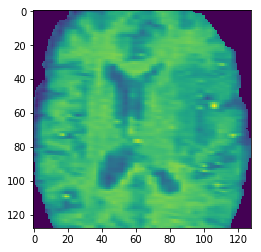

In [365]:
# Script for displaying predictions/masks from the test set

import matplotlib.pyplot as plt
import numpy as np
import settings_dist

# Load numpy arrays
data_dir = settings_dist.OUT_PATH
imgs_test = np.load('{}imgs_test.npy'.format(data_dir))
msks_test = np.load('{}msks_test.npy'.format(data_dir))
preds_test = np.load('{}msks_test_predictions.npy'.format(data_dir))

# Index of images to compare
index = 85

print(type(imgs_test[index][0,0,0]))

plt.imshow(imgs_test[index][:,:,3])
plt.show()

(240, 240, 155)
[[139 150 151 119 127 145 142 146 143 130 127 119 146 186 177 159 115 108
  173 180  78  69 196 202 176 149 129 149 147 143]
 [131 136 144 136 150 150 145 159 147 134 133 144 163 160 146 117  93 147
  179  88  67 213 244 171 151 128 121 129 140 147]
 [143 139 134 149 154 139 144 149 144 139 136 165 175 143 118 104 136 174
  161 174 221 214 174 133 117 139 147 129 128 133]
 [138 139 150 139 125 146 150 139 138 111 134 161 165 150 137 148 189 198
  189 212 191 152 132 103 138 176 151 153 155 154]
 [123 120 120 121 119 155 152 145 150 134 169 163 161 158 168 188 194 179
  172 162 143 121 106 111 143 152 136 144 143 151]
 [131 123 124 142 149 161 151 142 135 145 150 172 177 151 160 173 171 151
  147 129 118 119 126 132 124 125 123 132 130 147]
 [119 139 152 149 157 169 158 140 121 130 124 153 153 143 148 143 134 128
  127 109 132 146 132 134 143 140 129 143 144 149]
 [124 130 146 148 159 167 158 150 148 147 146 148 132 134 131 141 123 136
  151 126 134 131 132 146 145 120 1

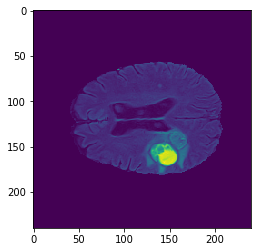

In [317]:
# Script for converting raw nifti files to numpy arrays

import nibabel as nib
import numpy.ma as ma
img = nib.load('/home/bduser/data_test/MICCAI_BraTS17_Data_Training/HGG/Brats17_CBICA_AXM_1/Brats17_CBICA_AXM_1_flair.nii.gz')
a = np.array(img.dataobj)

print(a.shape)

slice = 85

image = a[:,:,slice]
#img = ma.masked_not_equal(image,2).filled(fill_value=0)
#image = image[image==2]
#image = image[56:174, 56:174]
#print(img.shape)

print(image[80:110,160:190])
plt.imshow(image)
plt.show()

In [4]:
import os
import nibabel as nib
import numpy.ma as ma
import settings_dist
import numpy as np
import matplotlib.pyplot as plt

im_num = 85
channel = 2
resize = 128
train_test_split = 0.8

def parse_segments(seg):
    
    msks_parsed = []
    
    for slice in range(seg.shape[-1]):
        curr = seg[:,:,slice]
        GD = ma.masked_not_equal(curr,4).filled(fill_value=0)
        edema = ma.masked_not_equal(curr,2).filled(fill_value=0)
        necrotic = ma.masked_not_equal(curr,1).filled(fill_value=0)
        none = ma.masked_not_equal(curr,0).filled(fill_value=0)
        
        # Stack masks depth-wise
        msks_parsed.append(np.dstack((none,necrotic,edema,GD)))
    
    return np.asarray(msks_parsed)

def parse_images(img):
    
    slices = []
    for slice in range(img.shape[-1]):
        curr = img[:,:,slice]
        slices.append(curr)
    
    return np.asarray(slices)

def stack_img_slices(mode_track, stack_order):
    
    full_brain = []
    for slice in range(len(mode_track['t1'])):
        current_slice = []
        for mode in stack_order:
            current_slice.append(mode_track[mode][slice,:,:])
        full_brain.append(np.dstack(current_slice))

    return np.asarray(full_brain)

def resize_data(dataset, new_size):
    start_index = (dataset.shape[1] - new_size)/2
    end_index = dataset.shape[1] - start_index
    
    return dataset[:, start_index:end_index, start_index:end_index :]
    
root_dir = '/home/bduser/data_test/MICCAI_BraTS17_Data_Training'
imgs_all = []
msks_all = []
for subdir, dir, files in os.walk(root_dir):

    # Ensure all necessary files are present
    file_root = subdir.split('/')[-1] + "_"
    extension = ".nii.gz"
    img_modes = ["t1","t2","flair","t1ce"]
    need_file = [file_root + mode + extension for mode in img_modes]
    all_there = [(reqd in files) for reqd in need_file]
    if all(all_there):
        
        mode_track = {mode:[] for mode in img_modes}
        for file in files:
        
            if file.endswith('seg.nii.gz'):
                path = os.path.join(subdir,file)
                msk = np.array(nib.load(path).dataobj)
                parsed = resize_data(parse_segments(msk), resize)
                msks_all.extend(parsed)
            else:
                path = os.path.join(subdir,file)
                if file.endswith('t1.nii.gz'):
                    img = np.array(nib.load(path).dataobj)
                    mode_track['t1'] = parse_images(img)

                if file.endswith('t2.nii.gz'):
                    img = np.array(nib.load(path).dataobj)
                    mode_track['t2'] = parse_images(img)

                if file.endswith('t1ce.nii.gz'):
                    img = np.array(nib.load(path).dataobj)
                    mode_track['t1ce'] = parse_images(img)

                if file.endswith('flair.nii.gz'):
                    img = np.array(nib.load(path).dataobj)
                    mode_track['flair'] = parse_images(img)
        
        imgs_all.extend(resize_data(stack_img_slices(mode_track,img_modes), resize))

imgs_all = np.asarray(imgs_all, dtype=np.float64)
msks_all = np.asarray(msks_all)

# Resize images to 128*128 (default)
#if resize != 0:
#    imgs_all = resize_data(imgs_all, resize)
#    msks_all = resize_data(msks_all, resize)

#np.save("msks_all.npy", msks_all)
print("img shape: {}".format(imgs_all.shape))
print("msk shape: {}\n\n".format(msks_all.shape))

# Save training and test sets according to train_test_split ratio
train_size = int(msks_all.shape[0]*train_test_split)
save_path = settings_dist.OUT_TEST_PATH
np.save("{}NEW-msks_train.npy".format(save_path),msks_all[0:train_size,:,:,:])
np.save("{}NEW-msks_test.npy".format(save_path),msks_all[train_size:,:,:,:])
np.save("{}NEW-imgs_train.npy".format(save_path),imgs_all[0:train_size,:,:,:])
np.save("{}NEW-imgs_test.npy".format(save_path),msks_all[train_size:,:,:,:])

image = imgs_all[im_num]
mask = msks_all[im_num][:,:,channel]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image, cmap='gray')
ax2.imshow(mask)

KeyboardInterrupt: 

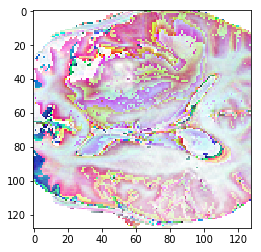

In [6]:

image = imgs_all[im_num]
mask = msks_all[im_num][:,:,channel]
plt.imshow(image, cmap='gray')
plt.show()

(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(240, 240, 155)
(4650, 240, 240, 4)


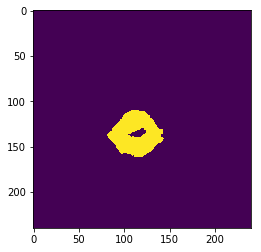

In [309]:
import os
import nibabel as nib
import numpy.ma as ma

im_num = 85
channel = 2

def parse_segments(seg):
    
    print(seg.shape)
    
    final_parsed = []
    
    for slice in range(seg.shape[-1]):
        curr = seg[:,:,slice]
        GD = ma.masked_not_equal(curr,4).filled(fill_value=0)
        edema = ma.masked_not_equal(curr,2).filled(fill_value=0)
        necrotic = ma.masked_not_equal(curr,1).filled(fill_value=0)
        none = ma.masked_not_equal(curr,0).filled(fill_value=0)
        fin = np.dstack((none,necrotic,edema,GD))
        final_parsed.append(fin)
    
    return np.asarray(final_parsed)
    
root_dir = '/home/bduser/data_test/MICCAI_BraTS17_Data_Training'
msks_all = []
for subdir, dir, files in os.walk(root_dir):
    for file in files:
        if file.startswith('Brats17_2013') & file.endswith('seg.nii.gz'):
            path = os.path.join(subdir,file)
            img = np.array(nib.load(path).dataobj)
            parsed = parse_segments(img)
            msks_all.extend(parsed)

msks_all = np.asarray(msks_all)
print(all_data.shape)

image = msks_all[im_num][:,:,channel]
plt.imshow(image)
plt.show()

In [4]:
import os
import nibabel as nib
import numpy.ma as ma
import settings_dist
import numpy as np
import matplotlib.pyplot as plt

im_num = 85
channel = 2
resize = 128
train_test_split = 0.8
save_path = settings_dist.OUT_TEST_PATH

def parse_segments(seg):
    
    msks_parsed = []
    
    for slice in range(seg.shape[-1]):
        curr = seg[:,:,slice]
        GD = ma.masked_not_equal(curr,4).filled(fill_value=0)
        edema = ma.masked_not_equal(curr,2).filled(fill_value=0)
        necrotic = ma.masked_not_equal(curr,1).filled(fill_value=0)
        none = ma.masked_not_equal(curr,0).filled(fill_value=0)
        
        # Stack masks depth-wise
        msks_parsed.append(np.dstack((none,necrotic,edema,GD)))
    
    return np.asarray(msks_parsed)

def parse_images(img):
    
    slices = []
    for slice in range(img.shape[-1]):
        curr = img[:,:,slice]
        slices.append(curr)
    
    return np.asarray(slices)

def stack_img_slices(mode_track, stack_order):
    
    full_brain = []
    
    print([(i, len(mode_track[i])) for i in mode_track])
    for slice in range(len(mode_track['t1'])):
        current_slice = []
        for mode in stack_order:
            current_slice.append(mode_track[mode][slice,:,:])
        full_brain.append(np.dstack(current_slice))

    return np.asarray(full_brain)

def resize_data(dataset, new_size):
    print(dataset.shape)
    start_index = (dataset.shape[1] - new_size)/2
    end_index = dataset.shape[1] - start_index

    return dataset[:, start_index:end_index, start_index:end_index :]

def save_data(imgs_all, msks_all, split, save_path):
    
    imgs_all = np.asarray(imgs_all, dtype=np.float64)
    msks_all = np.asarray(msks_all)
    
    train_size = int(msks_all.shape[0]*split)

    print("img shape: {}".format(imgs_all.shape))
    print("msk shape: {}\n\n".format(msks_all.shape))

    new_imgs_train = imgs_all[0:train_size,:,:,:]
    new_msks_train = msks_all[0:train_size,:,:,:]
    new_imgs_test = imgs_all[train_size:,:,:,:]
    new_msks_test = msks_all[train_size:,:,:,:]
    
    if os.path.isfile("{}NEW-imgs_train.npy".format(save_path)):
        
        imgs_train = np.load("{}NEW-imgs_train.npy".format(save_path))
        msks_train = np.load("{}NEW-msks_train.npy".format(save_path))
        imgs_test = np.load("{}NEW-imgs_test.npy".format(save_path))
        msks_test = np.load("{}NEW-msks_test.npy".format(save_path))
            
        np.save("{}NEW-imgs_train.npy".format(save_path), np.concatenate((imgs_train,new_imgs_train), axis = 0))
        np.save("{}NEW-msks_train.npy".format(save_path), np.concatenate((msks_train,new_msks_train), axis = 0))
        np.save("{}NEW-imgs_test.npy".format(save_path), np.concatenate((imgs_test,new_imgs_test), axis = 0))
        np.save("{}NEW-msks_test.npy".format(save_path), np.concatenate((imgs_test,new_imgs_test), axis = 0))

    else:
        
        np.save("{}NEW-imgs_train.npy".format(save_path), new_imgs_train)
        np.save("{}NEW-msks_train.npy".format(save_path), new_msks_train)
        np.save("{}NEW-imgs_test.npy".format(save_path), new_imgs_test)
        np.save("{}NEW-msks_test.npy".format(save_path), new_imgs_test)
        
    
root_dir = '/home/bduser/data_test/MICCAI_BraTS17_Data_Training'
imgs_all = []
msks_all = []
dummy = 0
for subdir, dir, files in os.walk(root_dir):

    # Ensure all necessary files are present
    file_root = subdir.split('/')[-1] + "_"
    extension = ".nii.gz"
    img_modes = ["t1","t2","flair","t1ce"]
    need_file = [file_root + mode + extension for mode in img_modes]
    all_there = [(reqd in files) for reqd in need_file]
    if all(all_there) and dummy < 25:
        
        mode_track = {mode:[] for mode in img_modes}
        for file in files:

            #if file.startswith('Brats17_2013'):

            if file.endswith('seg.nii.gz'):
                path = os.path.join(subdir,file)
                msk = np.array(nib.load(path).dataobj)
                parsed = resize_data(parse_segments(msk), resize)
                msks_all.extend(parsed)

            if file.endswith('t1.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t1'] = resize_data(parse_images(img), resize)

            if file.endswith('t2.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t2'] = resize_data(parse_images(img), resize)

            if file.endswith('t1ce.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t1ce'] = resize_data(parse_images(img), resize)

            if file.endswith('flair.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['flair'] = resize_data(parse_images(img), resize)
                
        dummy += 1
        imgs_all.extend(resize_data(stack_img_slices(mode_track,img_modes), resize))
        print("dummy: {0}, msks_all: {1}, imgs_all: {2}".format(dummy, len(msks_all), len(imgs_all)))

    if (dummy%6 == 0) & (dummy != 0):
        print("Total brains: {}".format(dummy))
        save_data(imgs_all, msks_all, train_test_split, save_path)
        imgs_all = []
        msks_all = []
        print("Saved checkpoint")

image = imgs_all[im_num]
mask = msks_all[im_num][:,:,channel]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(image, cmap='gray')
ax2.imshow(mask)
plt.show()

(155, 240, 240, 4)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
[('flair', 155), ('t2', 155), ('t1ce', 155), ('t1', 155)]
(155, 128, 128, 4)
dummy: 1, msks_all: 155, imgs_all: 155
(155, 240, 240, 4)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
[('flair', 155), ('t2', 155), ('t1ce', 155), ('t1', 155)]
(155, 128, 128, 4)
dummy: 2, msks_all: 310, imgs_all: 310
(155, 240, 240)
(155, 240, 240, 4)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
[('flair', 155), ('t2', 155), ('t1ce', 155), ('t1', 155)]
(155, 128, 128, 4)
dummy: 3, msks_all: 465, imgs_all: 465
(155, 240, 240, 4)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
[('flair', 155), ('t2', 155), ('t1ce', 155), ('t1', 155)]
(155, 128, 128, 4)
dummy: 4, msks_all: 620, imgs_all: 620
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240)
(155, 240, 240, 4)
[('flair', 155), ('t2', 155), ('t1ce', 155), ('t1', 155)]
(155, 128, 128, 4)
dummy: 5, msks_all: 775, imgs_all: 775
(155,

ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [8]:
import os
import nibabel as nib
import numpy.ma as ma
import settings_dist
import numpy as np
from tqdm import tqdm

root_dir = '/home/bduser/data_test/MICCAI_BraTS17_Data_Training'  # Replace with your BraTS data directory
resize = 128  # Final dimension (square), set resize = 0 if no resizing is desired
rotate = 3  # Number of counter-clockwise, 90 degree rotations
save_path = settings_dist.OUT_PATH
train_test_split = 0.85
save_interval = 25

def parse_segments(seg):
    
    # Each channel corresponds to a different region of the tumor, decouple and stack these
    
    msks_parsed = []
    for slice in range(seg.shape[-1]):
        curr = seg[:,:,slice]
        GD = ma.masked_not_equal(curr,4).filled(fill_value=0)
        edema = ma.masked_not_equal(curr,2).filled(fill_value=0)
        necrotic = ma.masked_not_equal(curr,1).filled(fill_value=0)
        none = ma.masked_not_equal(curr,0).filled(fill_value=0)

        msks_parsed.append(np.dstack((none,necrotic,edema,GD)))
    
    # Replace all tumorous areas with 1 (previously marked as 1, 2 or 4)
    mask = np.asarray(msks_parsed)
    mask[mask > 0] = 1

    return mask

def parse_images(img):
    
    slices = []
    for slice in range(img.shape[-1]):
        curr = img[:,:,slice]
        slices.append(curr)
    
    return np.asarray(slices)

def stack_img_slices(mode_track, stack_order):
    
    # Put final image channels in the order listed in stack_order
    
    full_brain = []
    for slice in range(len(mode_track['t1'])):
        current_slice = []
        for mode in stack_order:
            current_slice.append(mode_track[mode][slice,:,:])
        full_brain.append(np.dstack(current_slice))
    
    # Normalize stacked images (inference will not work if this is not performed)
    stack = np.asarray(full_brain)
    stack = (stack - np.mean(stack))/(np.std(stack))

    return stack

def resize_data(dataset, new_size):

    # Test/Train images must be the same size
    
    start_index = (dataset.shape[1] - new_size)/2
    end_index = dataset.shape[1] - start_index
    
    if rotate != 0:
        resized = np.rot90(dataset[:, start_index:end_index, start_index:end_index :], rotate, axes=(1,2))
    else:
        resized = dataset[:, start_index:end_index, start_index:end_index :]
    
    return resized

def save_data(imgs_all, msks_all, split, save_path):
    
    imgs_all = np.asarray(imgs_all)
    msks_all = np.asarray(msks_all)
    
    # Split entire dataset into train/test sets
    train_size = int(msks_all.shape[0]*split)
    new_imgs_train = imgs_all[0:train_size,:,:,:]
    new_msks_train = msks_all[0:train_size,:,:,:]
    new_imgs_test = imgs_all[train_size:,:,:,:]
    new_msks_test = msks_all[train_size:,:,:,:]
    
    if os.path.isfile("{}imgs_train.npy".format(save_path)):

        # Open one file at a time (these will be large) and clear buffer immediately after concatenate/save
        
        imgs_train = np.load("{}imgs_train.npy".format(save_path))
        np.save("{}imgs_train.npy".format(save_path), np.concatenate((imgs_train,new_imgs_train), axis = 0))
        imgs_train = []
        
        msks_train = np.load("{}msks_train.npy".format(save_path))
        np.save("{}msks_train.npy".format(save_path), np.concatenate((msks_train,new_msks_train), axis = 0))
        msks_train = []
        
        imgs_test = np.load("{}imgs_test.npy".format(save_path))
        np.save("{}imgs_test.npy".format(save_path), np.concatenate((imgs_test,new_imgs_test), axis = 0))
        imgs_test = []
        
        msks_test = np.load("{}msks_test.npy".format(save_path))
        np.save("{}msks_test.npy".format(save_path), np.concatenate((msks_test,new_msks_test), axis = 0))
        msks_test = []

    else:
        
        np.save("{}imgs_train.npy".format(save_path), new_imgs_train)
        np.save("{}msks_train.npy".format(save_path), new_msks_train)
        np.save("{}imgs_test.npy".format(save_path), new_imgs_test)
        np.save("{}msks_test.npy".format(save_path), new_msks_test)

imgs_all = []
msks_all = []
scan_count = 0

for subdir, dir, files in tqdm(os.walk(root_dir)):

    # Ensure all necessary files are present
    file_root = subdir.split('/')[-1] + "_"
    extension = ".nii.gz"
    img_modes = ["t1","t2","flair","t1ce"]
    need_file = [file_root + mode + extension for mode in img_modes]
    all_there = [(reqd in files) for reqd in need_file]
    if all(all_there):

        mode_track = {mode:[] for mode in img_modes}
        
        for file in files:

            if file.endswith('seg.nii.gz'):
                path = os.path.join(subdir,file)
                msk = np.array(nib.load(path).dataobj)
                parsed = resize_data(parse_segments(msk), resize)
                msks_all.extend(parsed)

            if file.endswith('t1.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t1'] = resize_data(parse_images(img), resize)

            if file.endswith('t2.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t2'] = resize_data(parse_images(img), resize)

            if file.endswith('t1ce.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['t1ce'] = resize_data(parse_images(img), resize)

            if file.endswith('flair.nii.gz'):
                path = os.path.join(subdir,file)
                img = np.array(nib.load(path).dataobj)
                mode_track['flair'] = resize_data(parse_images(img), resize)

        scan_count += 1
        imgs_all.extend(np.asarray(stack_img_slices(mode_track,img_modes)))

    if (scan_count%save_interval == 0) & (scan_count != 0):
        print("Total scans processed: {}".format(scan_count))
        save_data(imgs_all, msks_all, train_test_split, save_path)
        imgs_all = []
        msks_all = []

# Save any leftover files - may miss a few at the end if the dataset size changes, this will catch those
if len(imgs_all) > 0:
    save_data(imgs_all, msks_all, train_test_split, save_path)
    print("Total scans processed: {}\nDone.".format(scan_count))


HBox(children=(IntProgress(value=1, bar_style=u'info', max=1), HTML(value=u'')))

Total scans processed: 25
Total scans processed: 50

Total scans processed: 66
Done.


('img amax', 3.9255167586307116)
('msk amax', 1)
('pred amax', 1.0)
(8184, 128, 128, 4)
(154, 1, 1, 128, 128, 1)


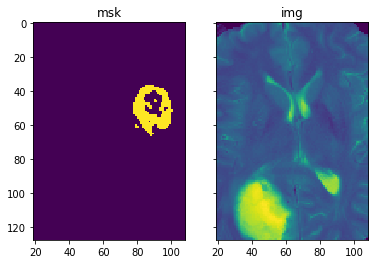

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

save_dir = "/home/bduser/unet/data/slices/testb/"
regulardir = "/home/bduser/unet/data/slices/Results/"
#pred = np.load(save_dir + "msks_test_predictions.npy")
msk_train = np.load(save_dir + "msks_train.npy")
img_test = np.load(save_dir + "imgs_test.npy")

old_msk = np.load(regulardir + "msks_test.npy")
old_img = np.load(regulardir + "imgs_test.npy")

slice = 77
msk_channel = 3

pred_img = pred[slice,0,0,:,:,0]
msk_img = msk[slice,:,:,msk_channel]
img_img = img[slice,:,:,1]

print("img amax",np.amax(img_img))
print("msk amax",np.amax(msk_img))
print("pred amax",np.amax(pred_img))
print(msk.shape)
print(pred.shape)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(msk_img)
ax1.set_title("msk")
ax2.imshow(img_img)
ax2.set_title("img")
#ax3.imshow(pred_img)
#ax3.set_title("pred")
plt.show()

('newshape', (154, 128, 128))


<IPython.core.display.Javascript object>


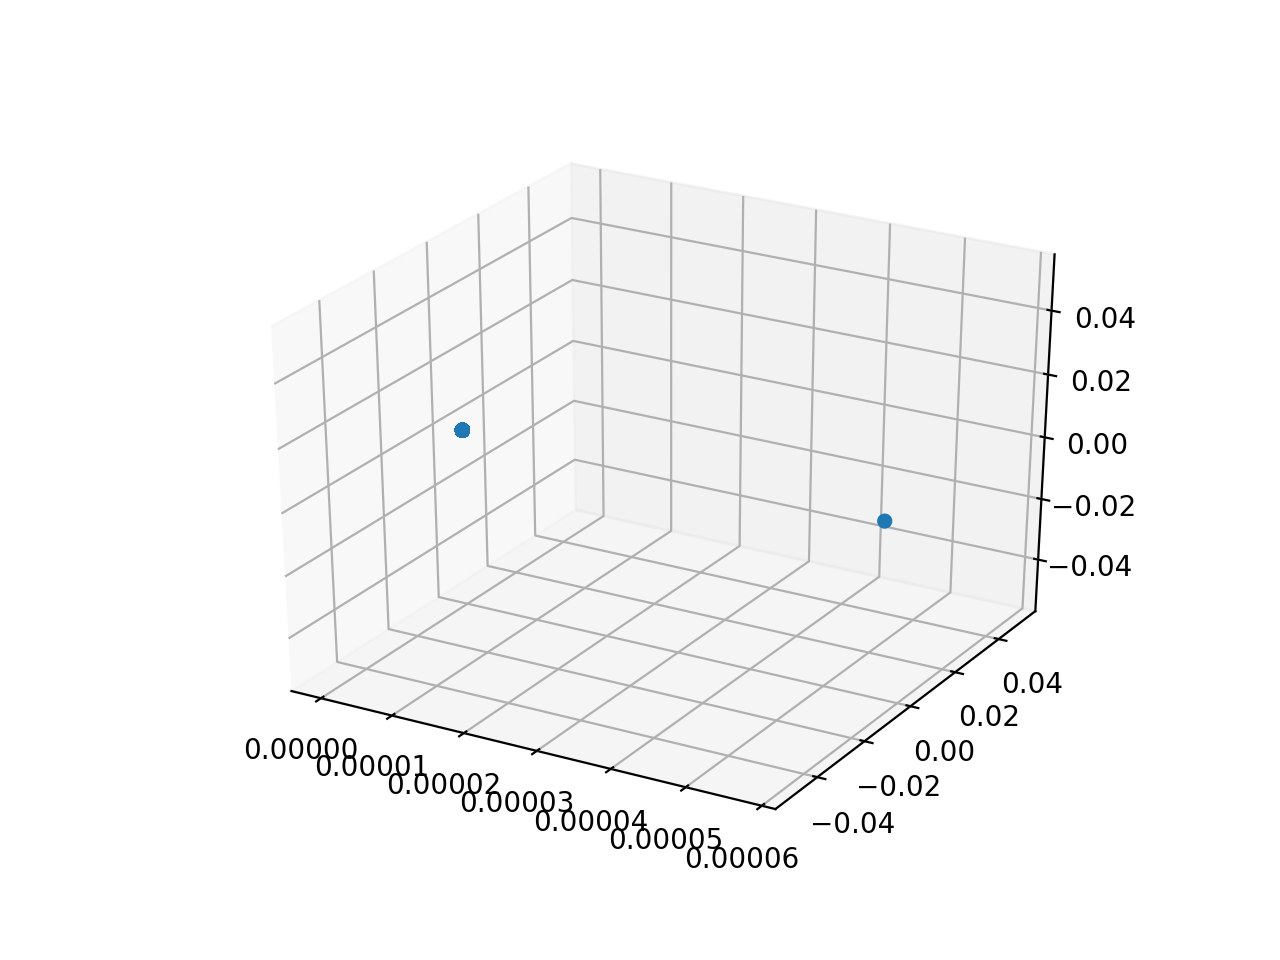

('here', 0.0)


In [23]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

save_dir = "/home/bduser/data_test/Brats17_TCIA_296_1/data/"
#regulardir = "/home/bduser/unet/data/slices/Results/"
pred = np.load(save_dir + "msks_test_predictions.npy")
#msk = np.load(save_dir + "msks_test.npy")
#img = np.load(save_dir + "imgs_test.npy")

#old_msk = np.load(regulardir + "msks_test.npy")
#old_img = np.load(regulardir + "imgs_test.npy")

slice = 77
msk_channel = 3

#pred_img = pred[slice,0,0,:,:,0]
#msk_img = msk[slice,:,:,msk_channel]
#img_img = img[slice,:,:,1]

#print("img amax",np.amax(img_img))
#print("msk amax",np.amax(msk_img))
#print("pred amax",np.amax(pred_img))
#print(msk.shape)
#print(pred.shape)

new = np.zeros((pred.shape[0],pred.shape[3],pred.shape[4]))
print("newshape",new.shape)
for slice in range(pred.shape[0]):
    for x in range(pred.shape[3]):
        for y in range(pred.shape[4]):
            if (slice %10 ==0) & (x%10 == 0) & (y%10 == 0) :
                new[slice,x,y] = pred[slice,:,:,x,y,0]

fig3d = plt.figure()
ax = fig3d.add_subplot(111, projection='3d')

x = pred[0]
y = pred[3]
z = pred[4]

print("here",np.amax(new[77,40,127]))

ax.scatter(list(new[0]),list(new[1]),list(new[2]))
plt.show()